<a href="https://colab.research.google.com/github/yatora200403/citrus-orange-disease-detection-20architectures/blob/main/Deteksi_Penyakit_buahjeruk_all_achitecture_batch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the requirements

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import time
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, AveragePooling2D, concatenate, MaxPooling2D, Conv2DTranspose, Input, Conv2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
# !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syarif200403","key":"e61df152342a40819b97cd7492e87c76"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'jonathansilva2020/orange-diseases-dataset'

Dataset URL: https://www.kaggle.com/datasets/jonathansilva2020/orange-diseases-dataset
License(s): CC-BY-NC-SA-4.0
 70% 97.0M/138M [00:00<00:00, 1.01GB/s]
100% 138M/138M [00:00<00:00, 922MB/s]  


<h2>Extract Dataset</h2>

In [ ]:
# Import library untuk handling zip file
import zipfile

In [ ]:
# Spesifikan  nama file
dataset_zip = zipfile.ZipFile('orange-diseases-dataset.zip','r')

# Extract
dataset_zip.extractall('orange-diseases-dataset')

# Tutup zip file
dataset_zip.close()

# Preprocessing

## resize image

In [ ]:
from PIL import Image

# Fungsi untuk memuat dan mengubah ukuran gambar menggunakan PIL
def load_and_resize_image(file_path, target_shape=(224, 224)):
    image = Image.open(file_path).convert('RGB')  # Membuka gambar dan mengonversi ke RGB
    resized_image = image.resize(target_shape)   # Mengubah ukuran gambar
    return np.array(resized_image)               # Mengembalikan gambar dalam bentuk array

In [ ]:
# Fungsi untuk memuat gambar dari direktori
def load_image_class_by_directory(image_dir):
    # Daftar file gambar di dalam direktori
    image_files = [file for file in os.listdir(image_dir) if file.lower().endswith('.jpg') or file.lower().endswith('.png')]
    images = [load_and_resize_image(os.path.join(image_dir, file)) for file in image_files]

    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [ ]:
# Menampilkan beberapa gambar
def display_images(images, num_images_to_display=6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

## change old names and change wrong image format

In [ ]:
# import shutil
# shutil.rmtree('/content/orange-diseases-dataset')

#mengganti nama folder yang tidak sesuai
old_names = ['blackspot', 'canker', 'fresh', 'grenning']
new_names = ['blackspot', 'cancer', 'fresh', 'greening']
train_path = '/content/orange-diseases-dataset/train/'
test_path = '/content/orange-diseases-dataset/test/'
for i,name in enumerate(old_names):
  os.rename(os.path.join(train_path, name), os.path.join(train_path,new_names[i]))
  os.rename(os.path.join(test_path, name), os.path.join(test_path,new_names[i]))

In [ ]:
#convert png to jpg
from PIL import Image

def convert_png_to_jpg(path):
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      img = img.convert('RGB')
      img.save(os.path.join(path, os.path.splitext(filename)[0] + '.jpg'))
      os.remove(os.path.join(path, filename))

fresh_train = '/content/orange-diseases-dataset/train/fresh/'
fresh_test = '/content/orange-diseases-dataset/test/fresh/'
convert_png_to_jpg(fresh_train)
convert_png_to_jpg(fresh_test)

Class **1** Sample (Blackspot)

Num of images: 184
Single image shape before flattening: (224, 224, 3)


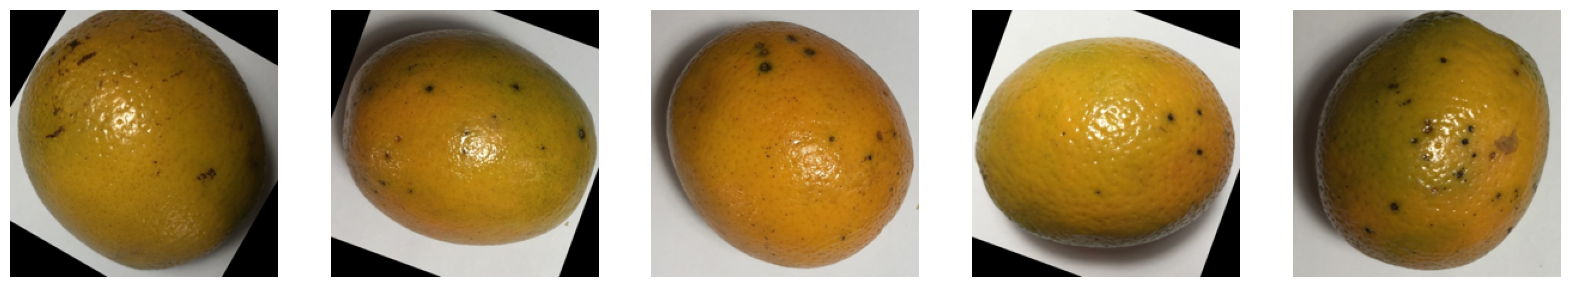

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/blackspot'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 2 Sample (Cancer)

Num of images: 179
Single image shape before flattening: (224, 224, 3)


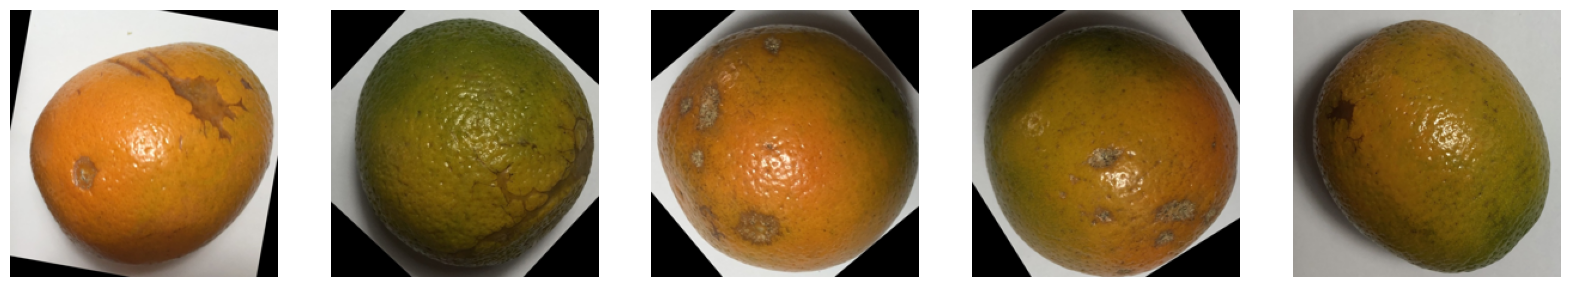

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/cancer'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 3 Sample (Greening)

Num of images: 347
Single image shape before flattening: (224, 224, 3)


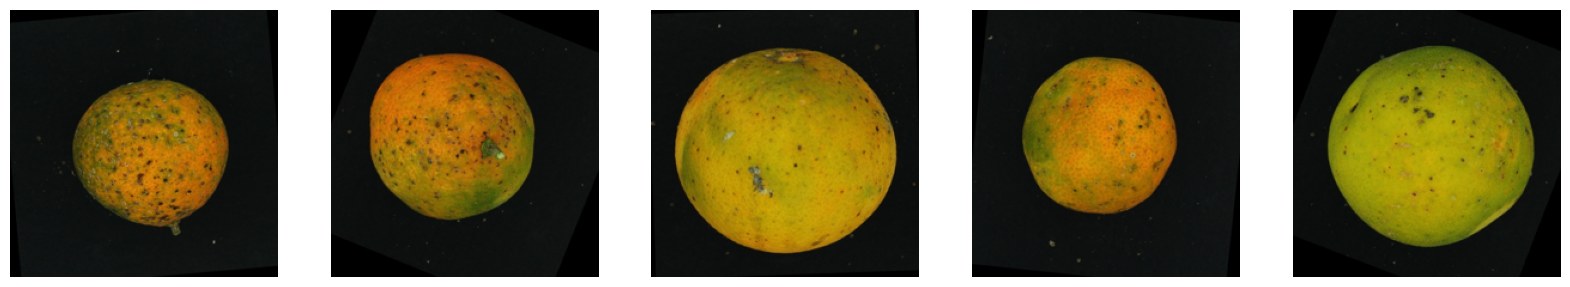

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/greening'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 4 Sample (Fresh)

Num of images: 281
Single image shape before flattening: (224, 224, 3)


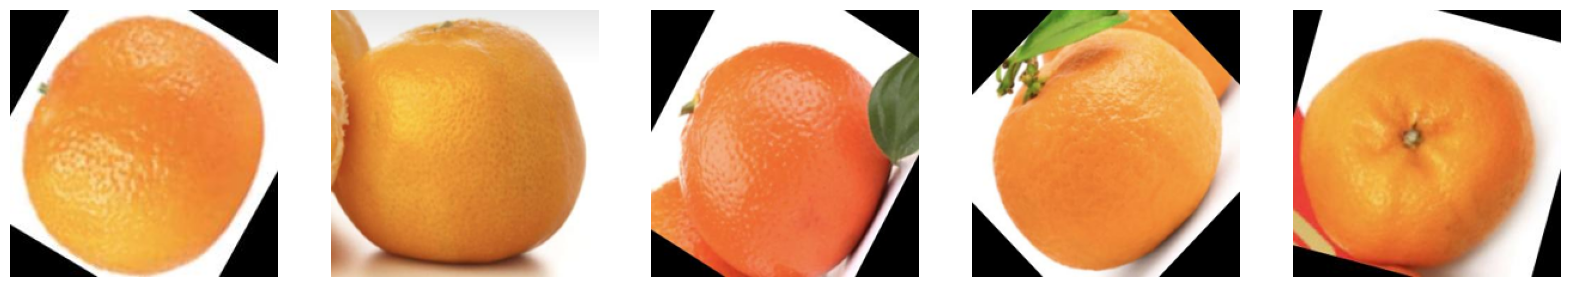

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

In [ ]:
def count_images_in_classes(base_dir):
    # Daftar semua subfolder dalam base_dir
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Iterasi untuk menghitung jumlah gambar setiap kelas
    for class_name in class_dirs:
        class_path = os.path.join(base_dir, class_name)
        # Hitung file dengan ekstensi .jpg atau .png
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith('.jpg') or f.lower().endswith('.png')])
        print(f"Disease: {class_name} --- Images: {num_images}")

# Path menuju direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

count_images_in_classes(base_dir)

Disease: blackspot --- Images: 184
Disease: fresh --- Images: 281
Disease: greening --- Images: 347
Disease: cancer --- Images: 179


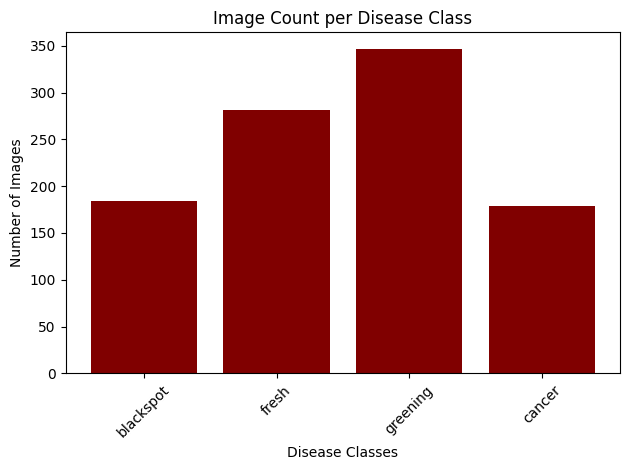

In [ ]:
def count_images_and_plot(base_dir):
    # Hitung jumlah gambar per kelas
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    class_counts = [len([f for f in os.listdir(os.path.join(base_dir, d)) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]) for d in class_dirs]

    # Buat chart
    plt.bar(class_dirs, class_counts, color='maroon')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.title('Image Count per Disease Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path menuju ke direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

# Hitung dan juga tampilkan chart
count_images_and_plot(base_dir)

## Data Augmentation

In [ ]:
def image_aug(path, img_class:str):
  img_list = []
  for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_list.append(img_array)


  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True
  )

  for img in img_list:
    img = img.reshape((1,) + img.shape)
    for batch in datagen.flow(img, batch_size=1, save_to_dir='/content/orange-diseases-dataset/train/'+img_class, save_prefix=img_class, save_format='jpg'):
      if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
        break
    if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
      break

disease_classes = ['blackspot','cancer','greening','fresh']
for disease in disease_classes:
  image_aug('/content/orange-diseases-dataset/train/'+disease, disease)

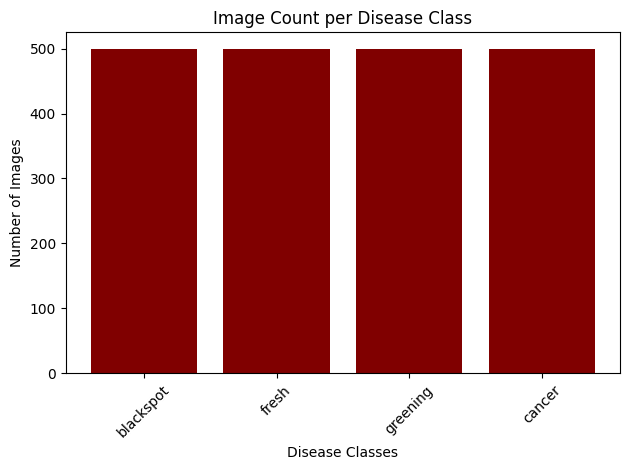

In [ ]:
count_images_and_plot(base_dir)
# plt.imshow(Image.open('/content/orange-diseases-dataset/train/blackspot/blackspot_0_150.jpg'))
# plt.axis('off')
# plt.show()

## Image Normalization

Found 2000 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Num of images: 500
Single image shape before flattening: (224, 224, 3)


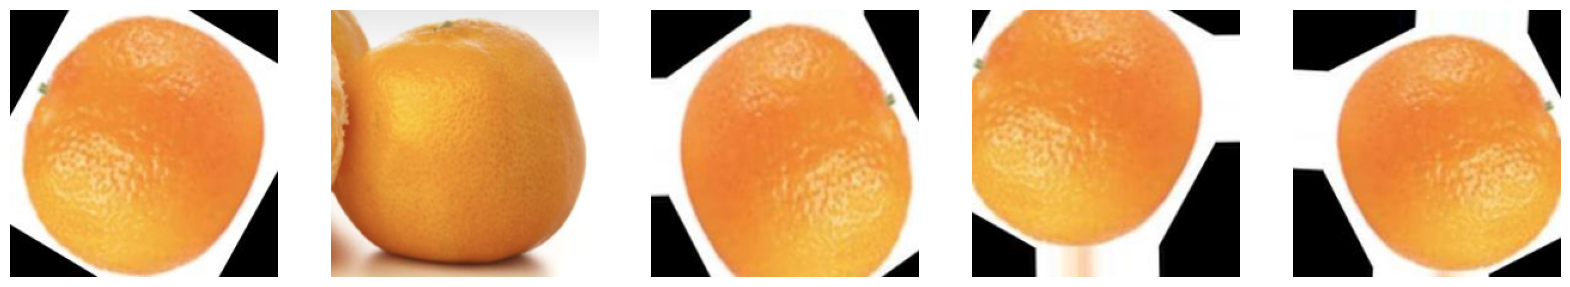

In [ ]:
datagen_normalized = ImageDataGenerator(rescale=1./255)

train_generator_normalized = datagen_normalized.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator_normalized = datagen_normalized.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

## Splitting Dataset into:

<ul>
  <li>training = 70%</li>
  <li>validation = 15%</li>
  <li>test = 15%</li>
</ul>

In [ ]:
dataset_path = Path('/content/orange-diseases-dataset/train')
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
#store all name of disease class names
class_names = train_ds.class_names

# Further split the validation dataset to create a test dataset
val_batches = int(0.5 * val_ds.cardinality().numpy())
valid_ds = val_ds.take(val_batches)
test_ds = val_ds.skip(val_batches)

# Print dataset information
print(f"Training batches: {train_ds.cardinality().numpy()}")
print(f"Validation batches: {valid_ds.cardinality().numpy()}")
print(f"Testing batches: {test_ds.cardinality().numpy()}")


Found 2000 files belonging to 4 classes.
Using 1400 files for training.
Found 2000 files belonging to 4 classes.
Using 600 files for validation.
Training batches: 44
Validation batches: 9
Testing batches: 10


# Training Process

## 1. AlexNet

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,763,396 (178.39 MB)

 Trainable params: 46,763,396 (178.39 MB)

 Non-trainable params: 0 (0.00 B)

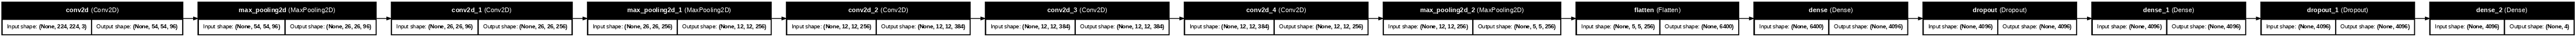

In [ ]:
# AlexNet architecture
model_alexnet = tf.keras.Sequential([
    # Layer 1: Convolutional Layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    # Layer 2: Max Pooling Layer
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    # Layer 3: Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    # Layer 4: Max Pooling Layer
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    # Layer 5: Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    # Layer 6: Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    # Layer 7: Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    # Layer 8: Max Pooling Layer
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    # Layer 9: Flatten Layer
    Flatten(),
    # Layer 10: Fully Connected Layer
    Dense(4096, activation='relu'),
    # Layer 11: Dropout Layer
    Dropout(0.5),
    # Layer 12: Fully Connected Layer
    Dense(4096, activation='relu'),
    # Layer 13: Dropout Layer
    Dropout(0.5),
    # Layer 14: Output Layer
    Dense(4, activation='softmax')
])

model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_alexnet.summary()
plot_model(model_alexnet, show_shapes=True, show_layer_names=True, dpi=50, rankdir="LR")

In [ ]:
starttime_alexnet = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_alexnet = model_alexnet.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_alexnet = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.4717 - loss: 6.7186 - val_accuracy: 0.9236 - val_loss: 0.2132
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.8962 - loss: 0.2670 - val_accuracy: 0.9097 - val_loss: 0.2388
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9217 - loss: 0.1825 - val_accuracy: 0.9028 - val_loss: 0.2363
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8829 - loss: 0.3424 - val_accuracy: 0.9549 - val_loss: 0.1106
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9545 - loss: 0.1193 - val_accuracy: 0.9479 - val_loss: 0.1002
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9559 - loss: 0.1091 - val_accuracy: 0.9479 - val_loss: 0.1174
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9661 - loss: 0.0911 - val_accuracy: 0.9688 - val_loss: 0.0702
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9656 - loss: 0.0900 - val_accuracy: 0.9792

## 2. GoogLeNet

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_6[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 28,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_4[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │      3,088 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ max_pooling2d_4[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │    110,720 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │     12,832 │ conv2d_11[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_8[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_10[0][0],  │
│                     │                   │            │ conv2d_12[0][0],  │
│                     │                   │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 5,977,652 (22.80 MB)

 Trainable params: 5,977,652 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

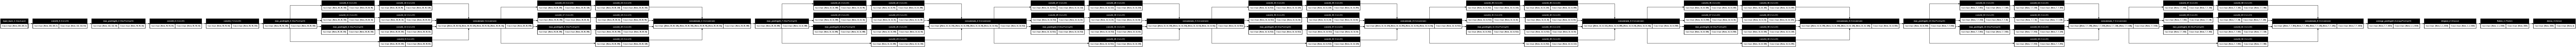

In [ ]:
# Define the Inception module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    return concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

# Input layer
input_tensor = tf.keras.Input(shape=(224, 224, 3))

# Initial convolutional layers
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception modules
x = inception_module(x, 64, 96, 128, 16, 32, 32)  # 3a
x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, 192, 96, 208, 16, 48, 64)  # 4a
# Optional: Add auxiliary classifiers here if needed for training

x = inception_module(x, 160, 112, 224, 24, 64, 64) # 4b
x = inception_module(x, 128, 128, 256, 24, 64, 64) # 4c
x = inception_module(x, 112, 144, 288, 32, 64, 64) # 4d
# Optional: Add auxiliary classifiers here if needed for training

x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b
x = AveragePooling2D((7, 7), strides=(1, 1))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

# Output layer
output_tensor = Dense(4, activation='softmax')(x)

# Create the model
model_googlenet = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model_googlenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

model_googlenet.summary()
plot_model(model_googlenet, show_shapes=True, show_layer_names=True, dpi=50, rankdir="LR")

In [ ]:
starttime_googlenet = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_googlenet = model_googlenet.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_googlenet = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 71s 777ms/step - accuracy: 0.4246 - loss: 1.2571 - val_accuracy: 0.8889 - val_loss: 0.2968
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.8676 - loss: 0.3207 - val_accuracy: 0.9097 - val_loss: 0.2003
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9262 - loss: 0.2059 - val_accuracy: 0.9306 - val_loss: 0.1634
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9483 - loss: 0.1286 - val_accuracy: 0.9132 - val_loss: 0.2648
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9494 - loss: 0.1265 - val_accuracy: 0.9236 - val_loss: 0.2387
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9436 - loss: 0.1417 - val_accuracy: 0.9236 - val_loss: 0.1917


## 3. ENet

In [ ]:
# Define the Initial block for ENet
def initial_block(input_tensor):
    conv = Conv2D(13, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    max_pool = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(input_tensor)
    concat = concatenate([conv, max_pool], axis=-1)
    return concat

# Define the Bottleneck block for ENet
def bottleneck_block(input_tensor, output_channels, internal_scale=4, asymmetric_kernel_size=0, dilation_rate=1, dropout_rate=0.1, regularizer=None):
    input_channels = input_tensor.shape[-1]
    bottleneck_channels = output_channels // internal_scale

    # Projection
    proj = Conv2D(bottleneck_channels, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(input_tensor)
    proj = BatchNormalization()(proj)
    proj = tf.keras.layers.PReLU(shared_axes=[1, 2])(proj)

    # Main path
    main = proj
    if asymmetric_kernel_size > 0:
        main = Conv2D(bottleneck_channels, (asymmetric_kernel_size, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
        main = BatchNormalization()(main)
        main = tf.keras.layers.PReLU(shared_axes=[1, 2])(main)
        main = Conv2D(bottleneck_channels, (1, asymmetric_kernel_size), padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
        main = BatchNormalization()(main)
        main = tf.keras.layers.PReLU(shared_axes=[1, 2])(main)
    elif dilation_rate > 1:
        main = Conv2D(bottleneck_channels, (3, 3), dilation_rate=dilation_rate, padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
        main = BatchNormalization()(main)
        main = tf.keras.layers.PReLU(shared_axes=[1, 2])(main)
    else:
        main = Conv2D(bottleneck_channels, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
        main = BatchNormalization()(main)
        main = tf.keras.layers.PReLU(shared_axes=[1, 2])(main)

    # Expansion
    main = Conv2D(output_channels, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
    main = BatchNormalization()(main)
    main = Dropout(dropout_rate)(main)

    # Shortcut
    if input_channels != output_channels:
        shortcut = Conv2D(output_channels, (1, 1), use_bias=False, kernel_regularizer=regularizer)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    # Addition
    add = layers.add([main, shortcut])
    output = tf.keras.layers.PReLU(shared_axes=[1, 2])(add)

    return output

# Define the Downsampling bottleneck block
def downsampling_bottleneck(input_tensor, output_channels, dropout_rate=0.1, regularizer=None):
    input_channels = input_tensor.shape[-1]
    bottleneck_channels = output_channels // 4

    # Main path (with projection and 2x2 convolution)
    proj = Conv2D(bottleneck_channels, (2, 2), strides=(2, 2), use_bias=False, kernel_regularizer=regularizer)(input_tensor)
    proj = BatchNormalization()(proj)
    proj = tf.keras.layers.PReLU(shared_axes=[1, 2])(proj)

    main = Conv2D(bottleneck_channels, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizer)(proj)
    main = BatchNormalization()(main)
    main = tf.keras.layers.PReLU(shared_axes=[1, 2])(main)

    main = Conv2D(output_channels, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
    main = BatchNormalization()(main)
    main = Dropout(dropout_rate)(main)

    # Shortcut path (with max pooling)
    shortcut = MaxPooling2D((2, 2), strides=(2, 2))(input_tensor)

    # Ensure the number of channels match for concatenation
    if shortcut.shape[-1] != output_channels:
        shortcut = Conv2D(output_channels, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(shortcut)
        shortcut = BatchNormalization()(shortcut)


    # Addition
    add = layers.add([main, shortcut])
    output = tf.keras.layers.PReLU(shared_axes=[1, 2])(add)

    return output

# Define the Upsampling bottleneck block
def upsampling_bottleneck(input_tensor, output_channels, dropout_rate=0.1, regularizer=None):
    input_channels = input_tensor.shape[-1]
    bottleneck_channels = output_channels // 4

    # Main path (with projection)
    proj = Conv2D(bottleneck_channels, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(input_tensor)
    proj = BatchNormalization()(proj)
    proj = tf.keras.layers.PReLU(shared_axes=[1, 2])(proj)

    main = Conv2DTranspose(bottleneck_channels, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizer)(proj)
    main = BatchNormalization()(main)
    main = tf.keras.layers.PReLU(shared_axes=[1, 2])(main)

    main = Conv2D(output_channels, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizer)(main)
    main = BatchNormalization()(main)
    main = Dropout(dropout_rate)(main)

    # Shortcut path (with transposed convolution)
    shortcut = Conv2DTranspose(output_channels, (2, 2), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizer)(input_tensor)
    shortcut = BatchNormalization()(shortcut)


    # Addition
    add = layers.add([main, shortcut])
    output = tf.keras.layers.PReLU(shared_axes=[1, 2])(add)

    return output

# Input layer
enet_input = tf.keras.Input(shape=(224, 224, 3))

# Initial Block
x = initial_block(enet_input)

# Stage 1
x = downsampling_bottleneck(x, 64, dropout_rate=0.01)
for _ in range(4):
    x = bottleneck_block(x, 64, dropout_rate=0.01)

# Stage 2
x = downsampling_bottleneck(x, 128, dropout_rate=0.1)
for _ in range(2):
    x = bottleneck_block(x, 128, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=2, dropout_rate=0.1)
x = bottleneck_block(x, 128, asymmetric_kernel_size=5, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=4, dropout_rate=0.1)
x = bottleneck_block(x, 128, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=8, dropout_rate=0.1)
x = bottleneck_block(x, 128, asymmetric_kernel_size=5, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=16, dropout_rate=0.1)


# Stage 3 (Same as Stage 2, excluding downsampling)
for _ in range(2):
    x = bottleneck_block(x, 128, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=2, dropout_rate=0.1)
x = bottleneck_block(x, 128, asymmetric_kernel_size=5, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=4, dropout_rate=0.1)
x = bottleneck_block(x, 128, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=8, dropout_rate=0.1)
x = bottleneck_block(x, 128, asymmetric_kernel_size=5, dropout_rate=0.1)
x = bottleneck_block(x, 128, dilation_rate=16, dropout_rate=0.1)

# Stage 4 (Upsampling)
x = upsampling_bottleneck(x, 64, dropout_rate=0.1)
x = bottleneck_block(x, 64, dropout_rate=0.1)
x = bottleneck_block(x, 64, dropout_rate=0.1)


# Stage 5 (Upsampling)
x = upsampling_bottleneck(x, 16, dropout_rate=0.1)
x = bottleneck_block(x, 16, dropout_rate=0.1)

# # Final Transposed Convolution
# x = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same')(x)

# # Output layer
# enet_output = tf.keras.layers.Activation('softmax')(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x) # Add global pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x) # Add dense layers for classification
x = Dropout(0.2)(x)
x = Dense(4, activation='softmax')(x) # Final dense layer for 4 classes

enet_output = x

# Create the model
model_enet = Model(inputs=enet_input, outputs=enet_output)

# Compile the model
model_enet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_enet.summary()
# plot_model(model_enet, show_shapes=True, show_layer_names=True, dpi=60, rankdir="TB")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 112, 112,  │        364 │ input_layer_2[0]… │
│                     │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 112, 112,  │          0 │ input_layer_2[0]… │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 112, 112,  │          0 │ conv2d_62[0][0],  │
│ (Concatenate)       │ 16)               │            │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 56, 56,    │      1,024 │ concatenate_9[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │         64 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 56, 56,    │         16 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 56, 56,    │      2,304 │ p_re_lu[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 56, 56,    │         16 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 56, 56,    │      1,024 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 56, 56,    │          0 │ concatenate_9[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 56, 56,    │      1,024 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ dropout_3[0][0],

 Total params: 448,704 (1.71 MB)

 Trainable params: 438,976 (1.67 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [ ]:
starttime_enet = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_enet = model_enet.fit(train_ds,
                              epochs=50,
                              validation_data=valid_ds,
                              callbacks=early_stopping)
endtime_enet = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.3009 - loss: 1.4123 - val_accuracy: 0.3403 - val_loss: 1.3660
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 194ms/step - accuracy: 0.3990 - loss: 1.2627 - val_accuracy: 0.2292 - val_loss: 1.3870
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.5354 - loss: 1.0771 - val_accuracy: 0.2118 - val_loss: 1.4057
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.6460 - loss: 0.9421 - val_accuracy: 0.2361 - val_loss: 1.4148


## 4. U-Net

In [ ]:
def double_conv_block(input_tensor, n_filters):
    x = Conv2D(n_filters, 3, padding="same", activation="relu")(input_tensor)
    x = Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    return x

def downsample_block(input_tensor, n_filters):
    f = double_conv_block(input_tensor, n_filters)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(input_tensor, conv_features, n_filters):
    x = Conv2DTranspose(n_filters, 3, strides=2, padding="same")(input_tensor)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

# Define the U-Net model for classification
def build_unet_classifier(input_shape=(224, 224, 3), n_classes=4):
    # Input layer
    inputs = Input(shape=input_shape)

    # Downsampling path
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Upsampling path
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Global Average Pooling and Dense layers for classification
    x = tf.keras.layers.GlobalAveragePooling2D()(u9)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Output layer (for classification)
    outputs = Dense(n_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Build the U-Net model
model_unet = build_unet_classifier(input_shape=(224, 224, 3), n_classes=4)

# Compile the model
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_unet.summary()
# plot_model(model_unet, show_shapes=True, show_layer_names=True, dpi=60, rankdir="TB")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 224, 224,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 224, 224,  │     36,928 │ conv2d_154[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 112, 112,  │          0 │ conv2d_155[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 112, 112,  │          0 │ max_pooling2d_19… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 112, 112,  │     73,856 │ dropout_33[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 112, 112,  │    147,584 │ conv2d_156[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 56, 56,    │          0 │ conv2d_157[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 56, 56,    │          0 │ max_pooling2d_20… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_158 (Conv2D) │ (None, 56, 56,    │    295,168 │ dropout_34[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_159 (Conv2D) │ (None, 56, 56,    │    590,080 │ conv2d_158[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 28, 28,    │          0 │ conv2d_159[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 28, 28,    │          0 │ max_pooling2d_21… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_160 (Conv2D) │ (None, 28, 28,    │  1,180,160 │ dropout_35[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_161 (Conv2D) │ (None, 28, 28,    │  2,359,808 │ conv2d_160[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 14, 14,    │          0 │ conv2d_161[0][0]  │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 14, 14,    │          0 │ max_pooling2d_22

 Total params: 34,522,116 (131.69 MB)

 Trainable params: 34,522,116 (131.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
starttime_unet = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_unet = model_unet.fit(train_ds,
                              epochs=50,
                              validation_data=valid_ds,
                              callbacks=early_stopping)
endtime_unet = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy: 0.3468 - loss: 2.1799 - val_accuracy: 0.9306 - val_loss: 0.7334
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7109 - loss: 0.7204 - val_accuracy: 0.8646 - val_loss: 0.2816
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8775 - loss: 0.3295 - val_accuracy: 0.9062 - val_loss: 0.2572
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9280 - loss: 0.2040 - val_accuracy: 0.9132 - val_loss: 0.2055
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9309 - loss: 0.1809 - val_accuracy: 0.9340 - val_loss: 0.1446
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9576 - loss: 0.1182 - val_accuracy: 0.9514 - val_loss: 0.1268
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9565 - loss: 0.1158 - val_accuracy: 0.9549 - val_loss: 0.0893
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9595 - loss: 0.1085 - val_accuracy: 0.9583 - val_los

# Training Performace

In [ ]:
number_of_architecture = 4
number_of_column = 2
number_of_row = int(number_of_architecture / number_of_column)
recall_list = []
precision_list = []
f1score_list = []
trainingtime_list = []
accuracy_list = []
val_accuracy_list = []
loss_list = []
val_loss_list = []
epochs_list = []

## training and validation performance

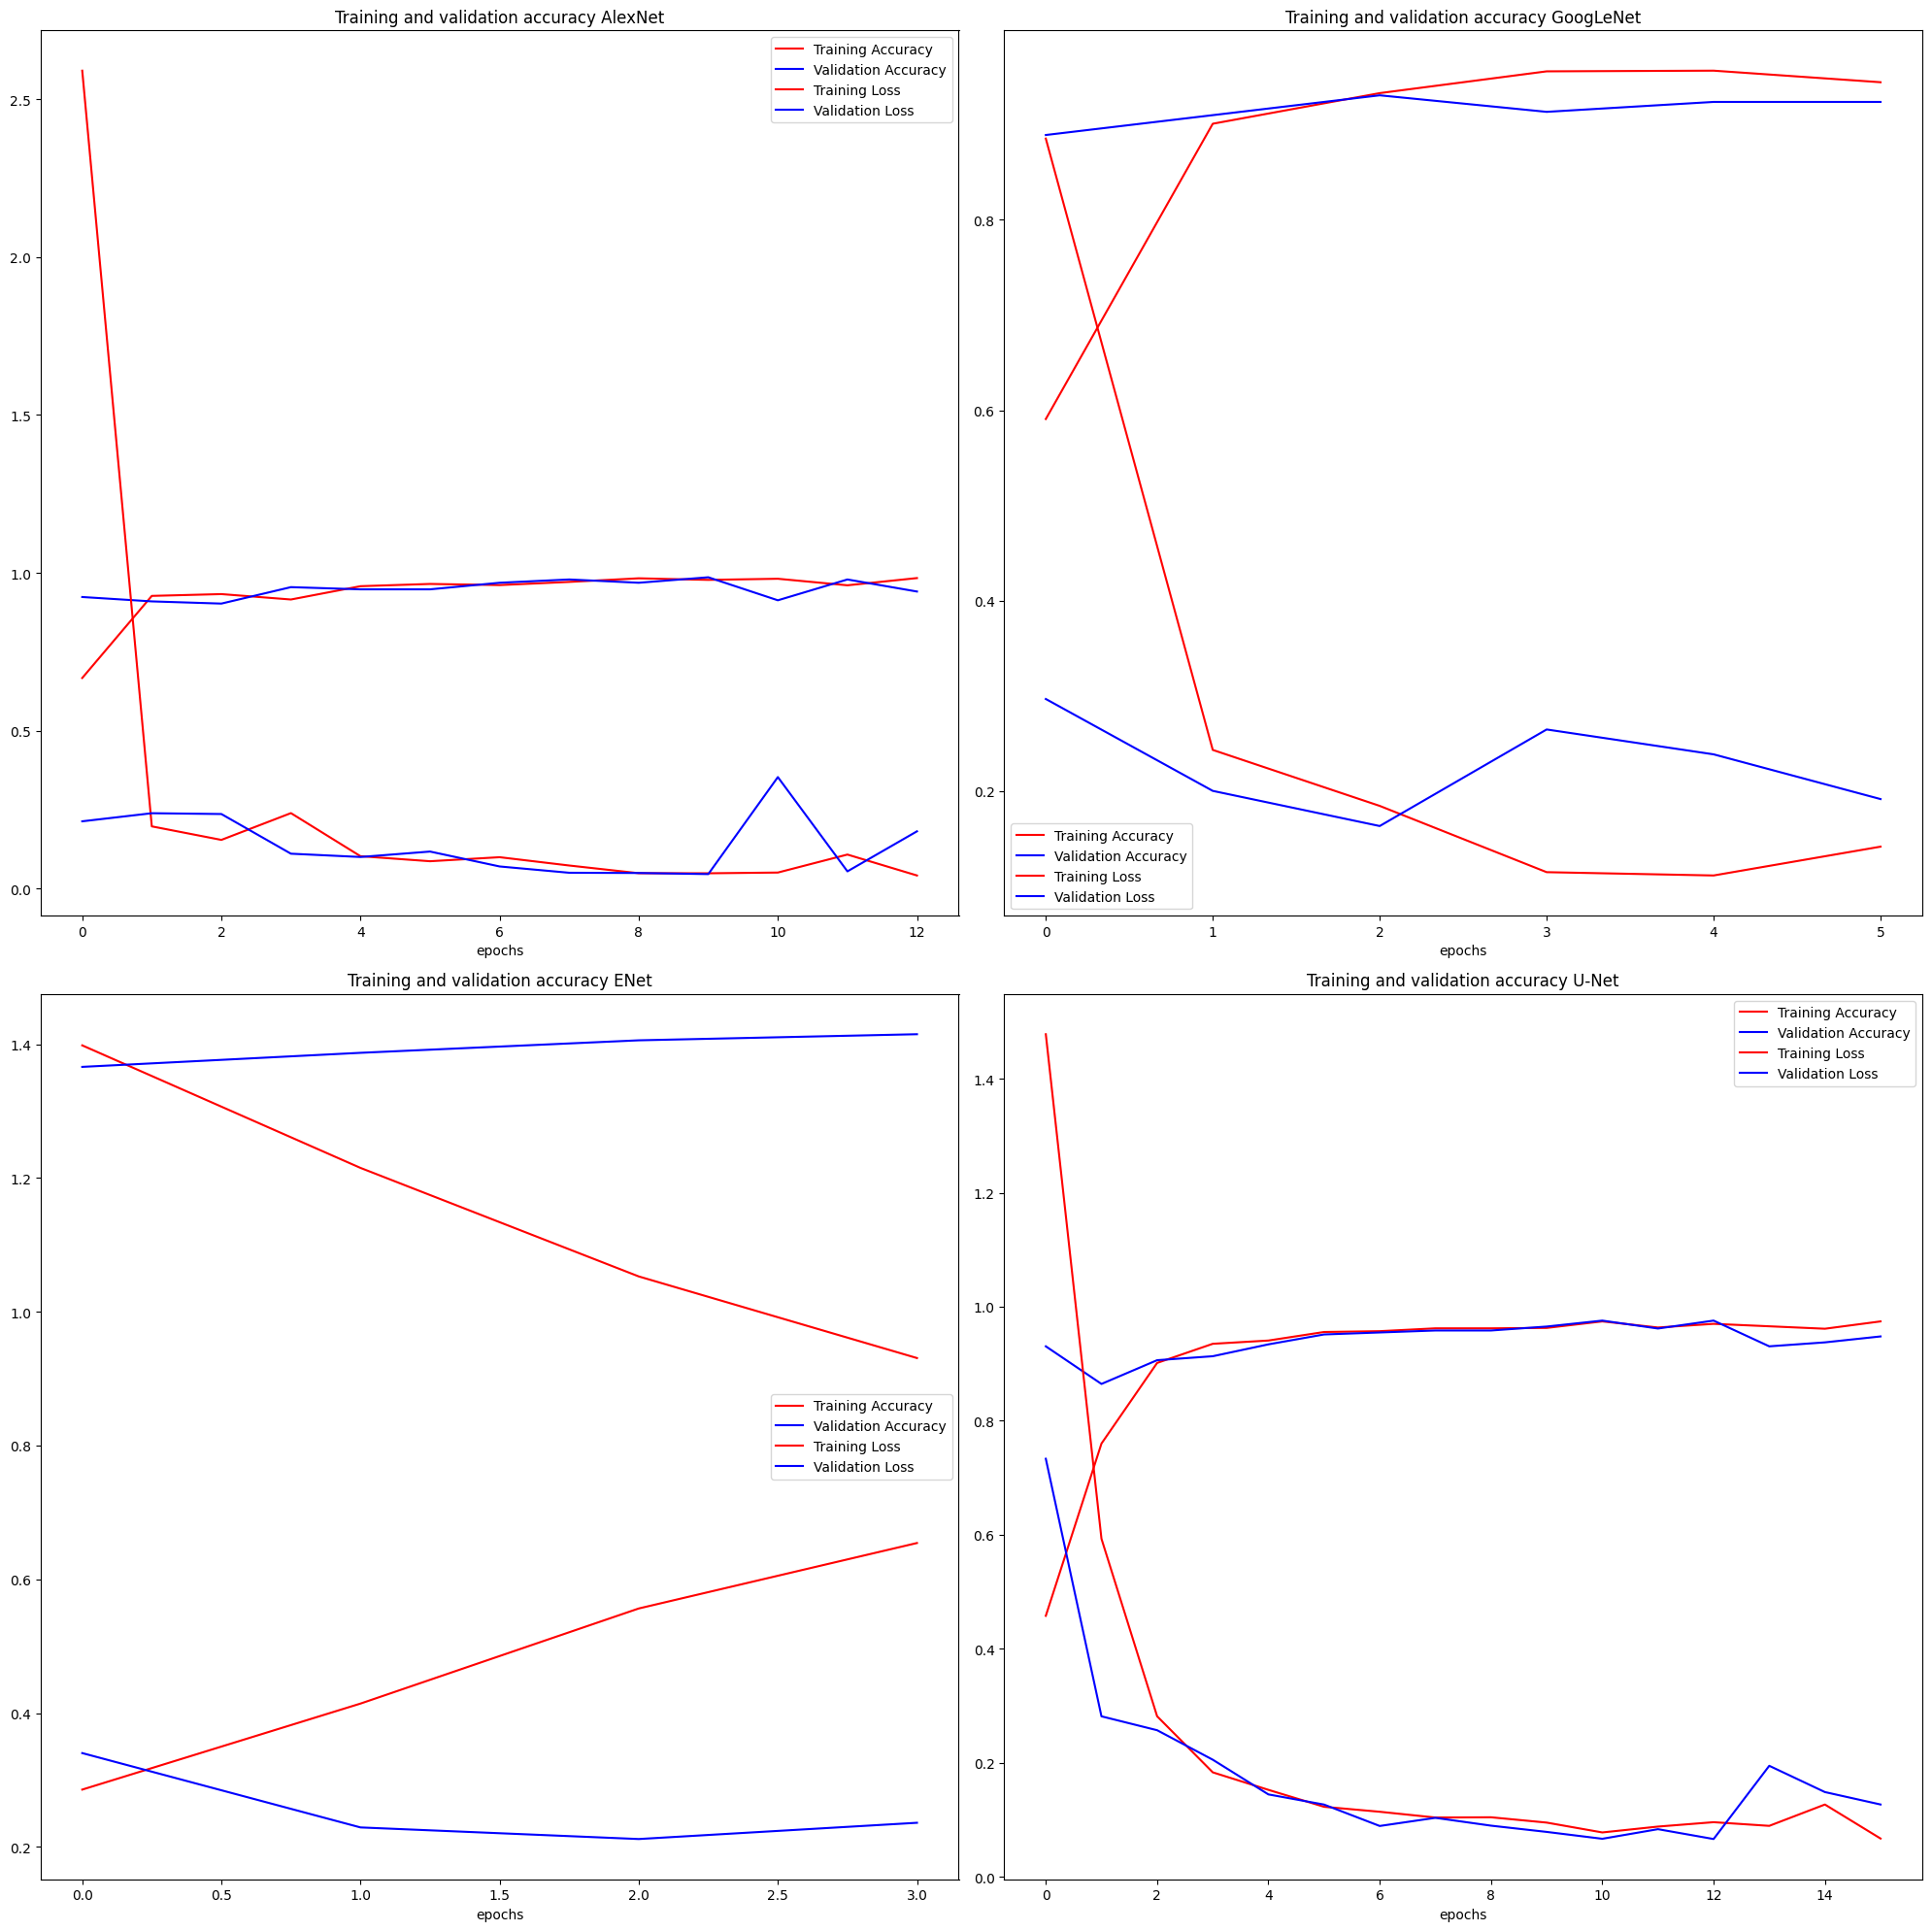

In [ ]:
fig, axes = plt.subplots(number_of_row, number_of_column, figsize=(20,20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

## AlexNet
# Get training and validation accuracies
acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']
loss = history_alexnet.history['loss']
val_loss = history_alexnet.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[0].set_title('Training and validation accuracy AlexNet')
axes[0].plot(epochs, acc, 'r', label="Training Accuracy")
axes[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[0].plot(epochs, loss, 'r', label="Training Loss")
axes[0].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[0].legend()
axes[0].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## GoogLeNet
# Get training and validation accuracies
acc = history_googlenet.history['accuracy']
val_acc = history_googlenet.history['val_accuracy']
loss = history_googlenet.history['loss']
val_loss = history_googlenet.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[1].set_title('Training and validation accuracy GoogLeNet')
axes[1].plot(epochs, acc, 'r', label="Training Accuracy")
axes[1].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[1].plot(epochs, loss, 'r', label="Training Loss")
axes[1].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[1].legend()
axes[1].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## ENet
# Get training and validation accuracies
acc = history_enet.history['accuracy']
val_acc = history_enet.history['val_accuracy']
loss = history_enet.history['loss']
val_loss = history_enet.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[2].set_title('Training and validation accuracy ENet')
axes[2].plot(epochs, acc, 'r', label="Training Accuracy")
axes[2].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[2].plot(epochs, loss, 'r', label="Training Loss")
axes[2].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[2].legend()
axes[2].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## U-Net
# Get training and validation accuracies
acc = history_unet.history['accuracy']
val_acc = history_unet.history['val_accuracy']
loss = history_unet.history['loss']
val_loss = history_unet.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[3].set_title('Training and validation accuracy U-Net')
axes[3].plot(epochs, acc, 'r', label="Training Accuracy")
axes[3].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[3].plot(epochs, loss, 'r', label="Training Loss")
axes[3].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[3].legend()
axes[3].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

plt.tight_layout()
plt.show()

###alternative

In [ ]:
# # Get training and validation accuracies
# acc = history_mobilenetv3large.history['accuracy']
# val_acc = history_mobilenetv3large.history['val_accuracy']
# loss = history_mobilenetv3large.history['loss']
# val_loss = history_mobilenetv3large.history['val_loss']
# # Get number of epochs
# epochs = range(len(acc))
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Training and validation accuracy MobileNetV3Large')
# for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
#     ax[i].plot(epochs, data[0], 'r', label="Training " + label)
#     ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
#     ax[i].legend()
#     ax[i].set_xlabel('epochs')
# plt.show()

## y_true and y_pred

In [ ]:
# AlexNet
print("AlexNet")
y_true_alexnet = []
y_pred_alexnet = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_alexnet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_alexnet.extend(true_labels)
    y_pred_alexnet.extend(predicted_labels)

# GoogLeNet
print("GoogLeNet")
y_true_googlenet = []
y_pred_googlenet = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_googlenet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_googlenet.extend(true_labels)
    y_pred_googlenet.extend(predicted_labels)

# ENet
print("ENet")
y_true_enet = []
y_pred_enet = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_enet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_enet.extend(true_labels)
    y_pred_enet.extend(predicted_labels)

# U-Net
print("U-Net")
y_true_unet = []
y_pred_unet = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_unet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_unet.extend(true_labels)
    y_pred_unet.extend(predicted_labels)

AlexNet
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
GoogLeNet
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
ENet
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

## training time

In [ ]:
# AlexNet Training
trainingtime_alexnet = endtime_alexnet - starttime_alexnet
print(f"AlexNet training time: {trainingtime_alexnet:.2f} seconds")
trainingtime_list.append(trainingtime_alexnet)

print("-" * 10)

# GoogLeNet Training
trainingtime_googlenet = endtime_googlenet - starttime_googlenet
print(f"GoogLeNet training time: {trainingtime_googlenet:.2f} seconds")
trainingtime_list.append(trainingtime_googlenet)

print("-" * 10)

# ENet Training
trainingtime_enet = endtime_enet - starttime_enet
print(f"ENet training time: {trainingtime_enet:.2f} seconds")
trainingtime_list.append(trainingtime_enet)

print("-" * 10)

# U-Net Training
trainingtime_unet = endtime_unet - starttime_unet
print(f"U-Net training time: {trainingtime_unet:.2f} seconds")
trainingtime_list.append(trainingtime_unet)

AlexNet training time: 79.84 seconds
----------
GoogLeNet training time: 98.47 seconds
----------
ENet training time: 233.66 seconds
----------
U-Net training time: 1518.50 seconds


## Recall

In [ ]:
# AlexNet
print("AlexNet")
test_loss, test_acc = model_alexnet.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# GoogLeNet
print("GoogLeNet")
test_loss, test_acc = model_googlenet.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# ENet
print("ENet")
test_loss, test_acc = model_enet.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# U-Net
print("U-Net")
test_loss, test_acc = model_unet.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

AlexNet
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9905 - loss: 0.0292
Test Accuracy: 0.9957143068313599
Test Loss: 0.01940189301967621
----------
GoogLeNet
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9445 - loss: 0.1443
Test Accuracy: 0.9457142949104309
Test Loss: 0.12913113832473755
----------
ENet
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.3316 - loss: 1.3656
Test Accuracy: 0.32357141375541687
Test Loss: 1.3665574789047241
----------
U-Net
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 488ms/step - accuracy: 0.9748 - loss: 0.0620
Test Accuracy: 0.9750000238418579
Test Loss: 0.057873278856277466


## Precission

In [ ]:
# AlexNet
precision = precision_score(y_true_alexnet, y_pred_alexnet, average='weighted')
print(f"Precision AlexNet: {precision}")
precision_list.append(precision)

print("-" * 10)

# GoogLeNet
precision = precision_score(y_true_googlenet, y_pred_googlenet, average='weighted')
print(f"Precision GoogLeNet: {precision}")
precision_list.append(precision)

print("-" * 10)

# ENet
precision = precision_score(y_true_enet, y_pred_enet, average='weighted')
print(f"Precision ENet: {precision}")
precision_list.append(precision)

print("-" * 10)

# U-Net
precision = precision_score(y_true_unet, y_pred_unet, average='weighted')
print(f"Precision U-Net: {precision}")
precision_list.append(precision)

Precision AlexNet: 0.9751189979848516
----------
Precision GoogLeNet: 0.946826923076923
----------
Precision ENet: 0.202775234025234
----------
Precision U-Net: 0.9759947482236638


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## F1-score

In [ ]:
# AlexNet
f1 = f1_score(y_true_alexnet, y_pred_alexnet, average='weighted')
print(f"F1 Score AlexNet: {f1}")
f1score_list.append(f1)

print("-" * 10)

# GoogLeNet
f1 = f1_score(y_true_googlenet, y_pred_googlenet, average='weighted')
print(f"F1 Score GoogLeNet: {f1}")
f1score_list.append(f1)

print("-" * 10)

# ENet
f1 = f1_score(y_true_enet, y_pred_enet, average='weighted')
print(f"F1 Score ENet: {f1}")
f1score_list.append(f1)

print("-" * 10)

# U-Net
f1 = f1_score(y_true_unet, y_pred_unet, average='weighted')
print(f"F1 Score U-Net: {f1}")
f1score_list.append(f1)

F1 Score AlexNet: 0.9745109290279342
----------
F1 Score GoogLeNet: 0.9310757150736475
----------
F1 Score ENet: 0.2578271658215557
----------
F1 Score U-Net: 0.9743496706486547


## Confusion matrix

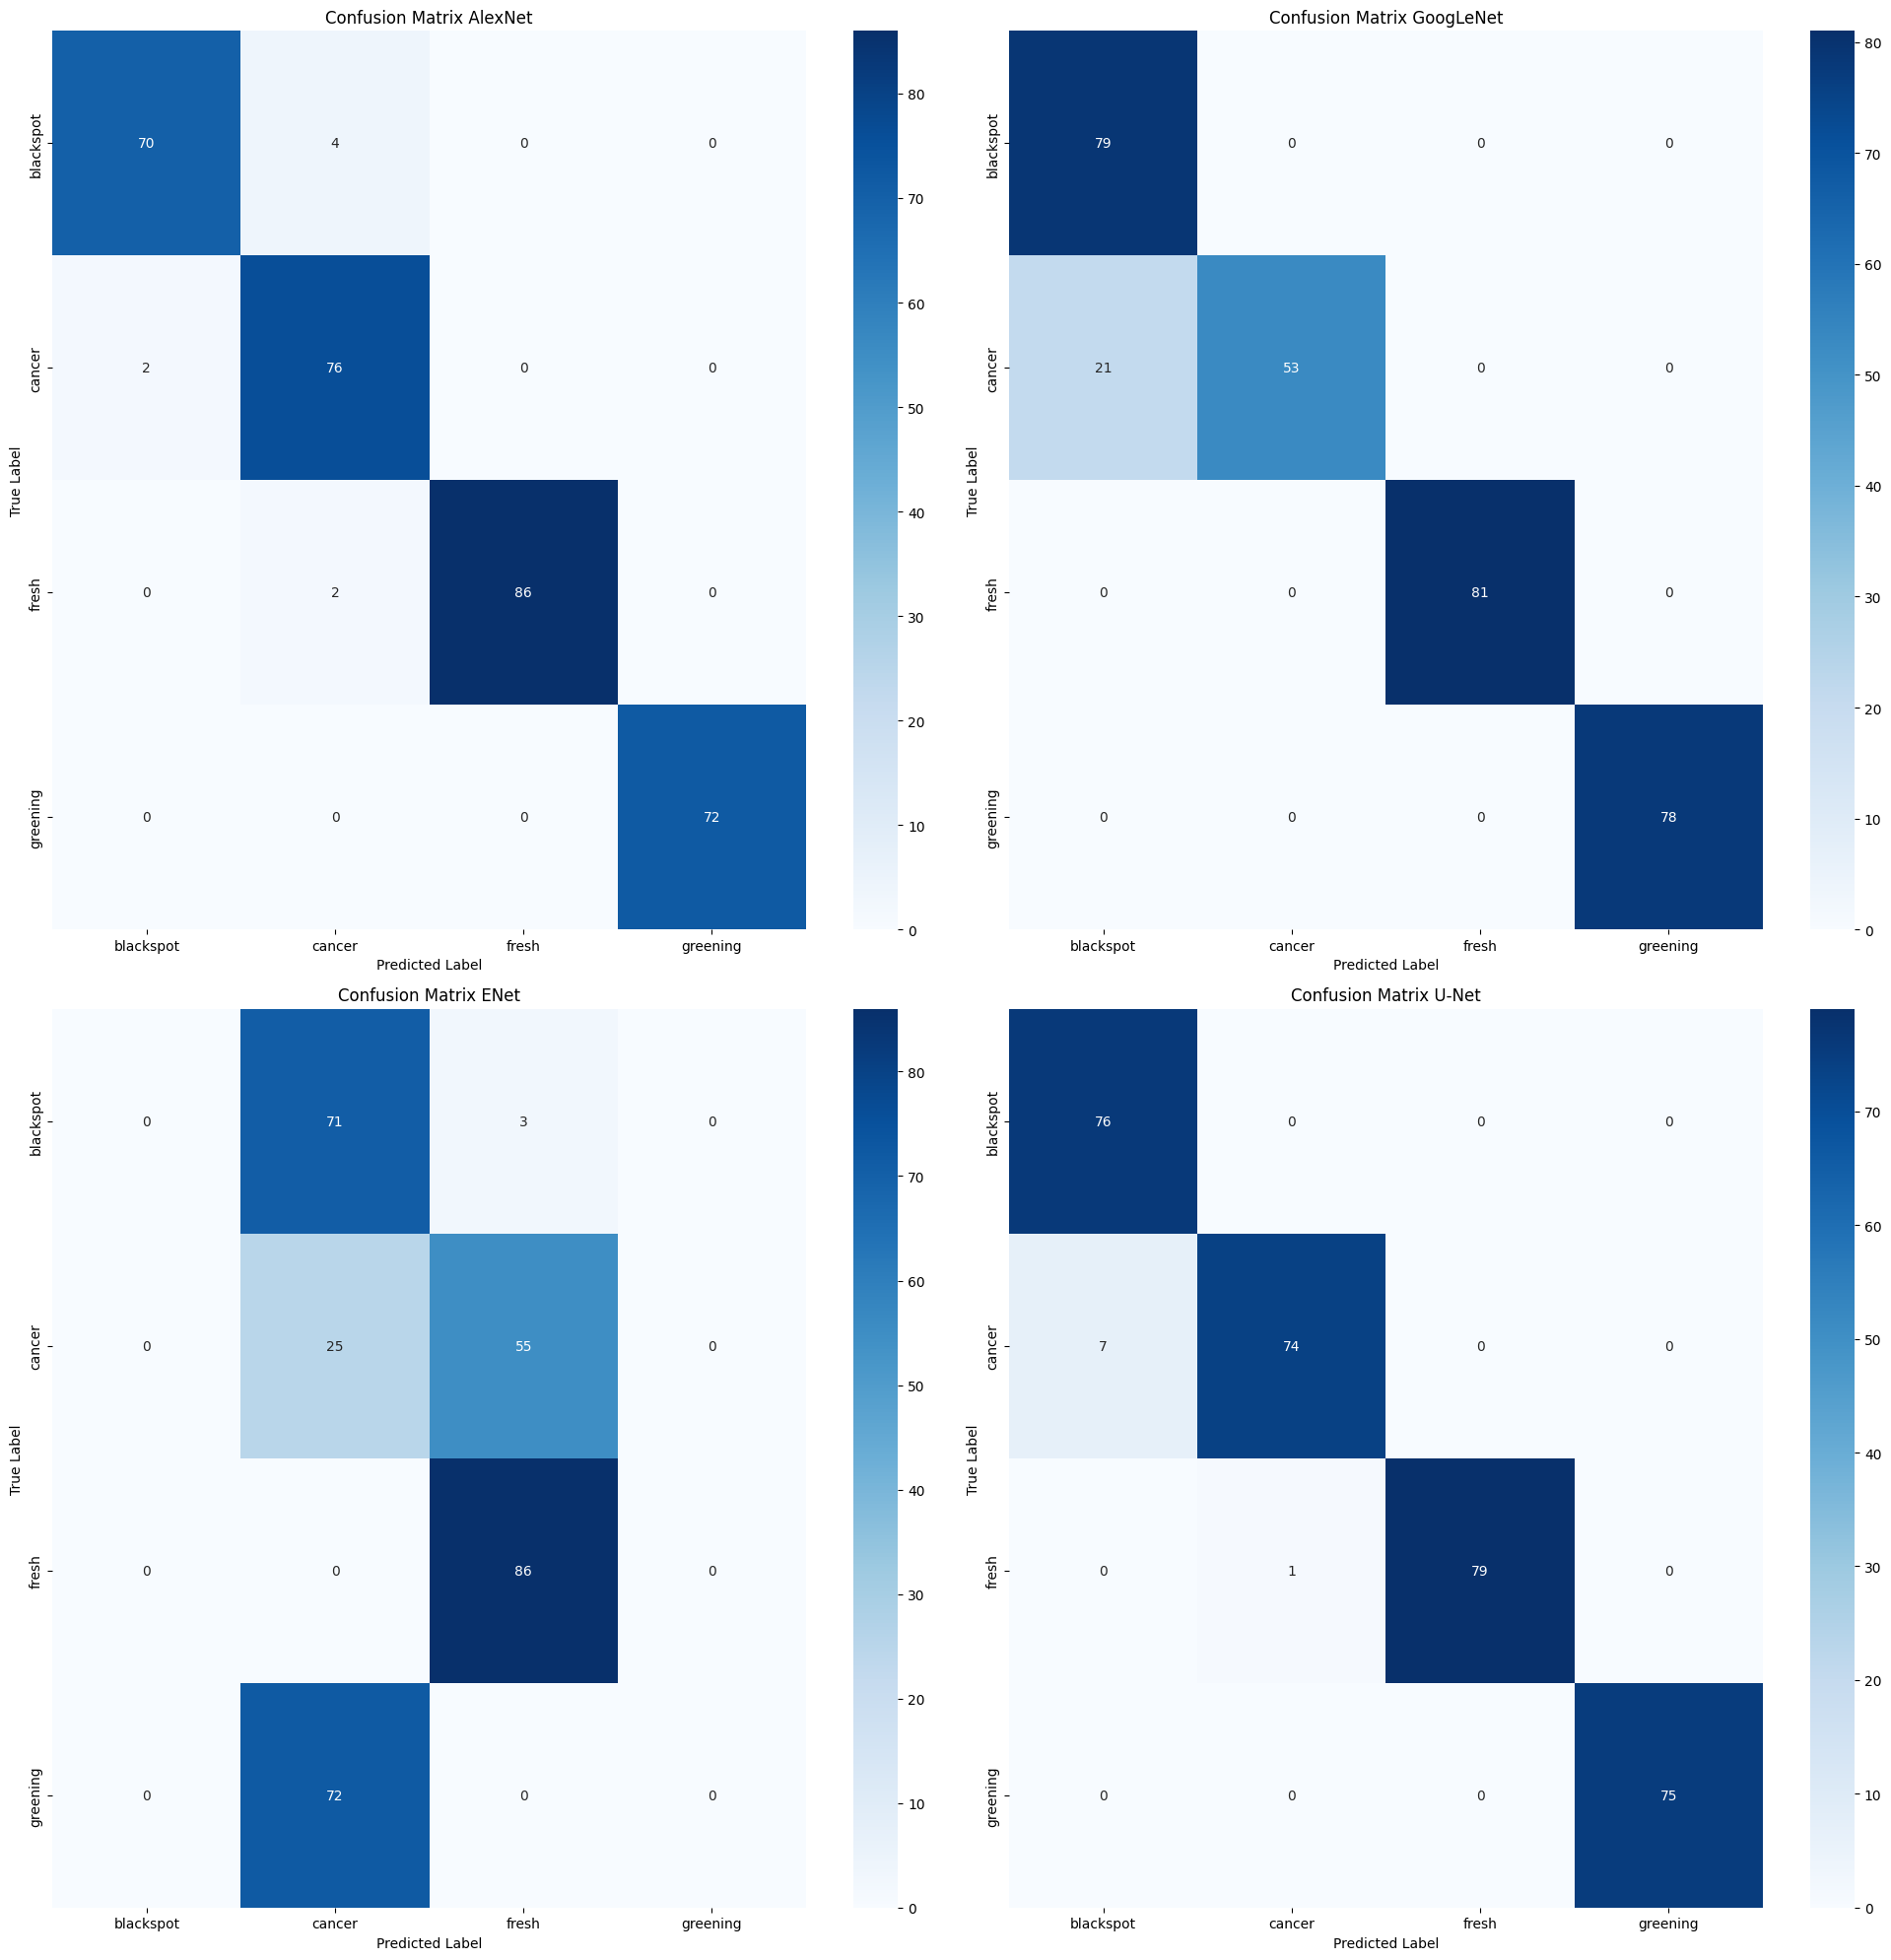

In [ ]:
## All architecture subplot
fig, axes = plt.subplots(number_of_row, number_of_column, figsize=(20, 20))

axes = axes.flatten()

## AlexNet
cm = confusion_matrix(y_true_alexnet, y_pred_alexnet)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix AlexNet')

## GoogLeNet
cm = confusion_matrix(y_true_googlenet, y_pred_googlenet)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix GoogLeNet')

## ENet
cm = confusion_matrix(y_true_enet, y_pred_enet)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('Confusion Matrix ENet')

## U-Net
cm = confusion_matrix(y_true_unet, y_pred_unet)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[3])
axes[3].set_xlabel('Predicted Label')
axes[3].set_ylabel('True Label')
axes[3].set_title('Confusion Matrix U-Net')

fig.tight_layout()
plt.show()

## test case

Testing with image: /content/orange-diseases-dataset/test/greening/g (2).jpg


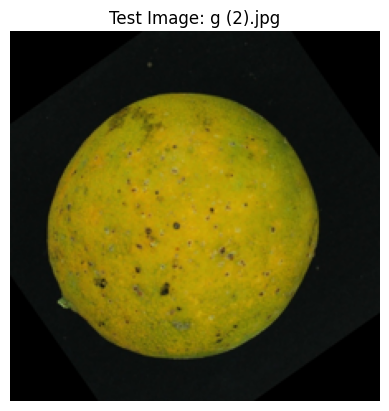



AlexNet:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class index: 3
Predicted label: greening
----------
GoogLeNet:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 3
Predicted label: greening
----------
ENet:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 1
Predicted label: cancer
----------
U-Net:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class index: 3
Predicted label: greening


In [ ]:
# Select one image from the test folder
test_dir = '/content/orange-diseases-dataset/test/'
# Get a list of all subdirectories (disease classes) in the test directory
disease_classes_test = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

if not disease_classes_test:
    print("No disease class subdirectories found in the test directory.")
else:
    # Choose the first disease class found (you can modify this to choose a specific class)
    chosen_disease_class = disease_classes_test[2]
    chosen_class_path = os.path.join(test_dir, chosen_disease_class)

    # Get a list of all files in the chosen disease class directory
    image_files = [f for f in os.listdir(chosen_class_path) if f.lower().endswith(('.jpg', '.png'))]

    if not image_files:
        print(f"No images found in the directory: {chosen_class_path}")
    else:
        # Choose the first image file found (you can modify this to choose a specific image)
        test_image_path = os.path.join(chosen_class_path, image_files[0])
        print(f"Testing with image: {test_image_path}")

        # Load and preprocess the image
        img = load_and_resize_image(test_image_path)
        img_array = np.expand_dims(img, axis=0) / 255.0

        # Display the test image
        plt.imshow(img)
        plt.title(f"Test Image: {os.path.basename(test_image_path)}")
        plt.axis('off')
        plt.show()

        # Make predictions with each model
        print("\n")
        # AlexNet
        print("AlexNet:")
        predictions_alexnet = model_alexnet.predict(img_array)
        predicted_class_alexnet = np.argmax(predictions_alexnet, axis=1)[0]
        predicted_label_alexnet = class_names[predicted_class_alexnet]
        print(f"Predicted class index: {predicted_class_alexnet}")
        print(f"Predicted label: {predicted_label_alexnet}")

        print("-" * 10)

        # GoogLeNet
        print("GoogLeNet:")
        predictions_googlenet = model_googlenet.predict(img_array)
        predicted_class_googlenet = np.argmax(predictions_googlenet, axis=1)[0]
        predicted_label_googlenet = class_names[predicted_class_googlenet]
        print(f"Predicted class index: {predicted_class_googlenet}")
        print(f"Predicted label: {predicted_label_googlenet}")

        print("-" * 10)

        # ENet
        print("ENet:")
        predictions_enet = model_enet.predict(img_array)
        predicted_class_enet = np.argmax(predictions_enet, axis=1)[0]
        predicted_label_enet = class_names[predicted_class_enet]
        print(f"Predicted class index: {predicted_class_enet}")
        print(f"Predicted label: {predicted_label_enet}")

        print("-" * 10)

        # U-Net
        print("U-Net:")
        predictions_unet = model_unet.predict(img_array)
        predicted_class_unet = np.argmax(predictions_unet, axis=1)[0]
        predicted_label_unet = class_names[predicted_class_unet]
        print(f"Predicted class index: {predicted_class_unet}")
        print(f"Predicted label: {predicted_label_unet}")

## Performance Table

In [ ]:
import pandas as pd
import numpy as np

# Function to get trainable and non-trainable parameters
def get_model_params(model):
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    return trainable_params, non_trainable_params

# Extracting the number of epochs the model was actually trained for (due to early stopping)
epochs_alexnet = len(history_alexnet.history['accuracy'])
epochs_googlenet = len(history_googlenet.history['accuracy'])
epochs_enet = len(history_enet.history['accuracy'])
epochs_unet = len(history_unet.history['accuracy'])


# Get trainable and non-trainable parameters for each model
trainable_alexnet, non_trainable_alexnet = get_model_params(model_alexnet)
trainable_googlenet, non_trainable_googlenet = get_model_params(model_googlenet)
trainable_enet, non_trainable_enet = get_model_params(model_enet)
trainable_unet, non_trainable_unet = get_model_params(model_unet)

# Create the DataFrame
data = {
    'Architecture': ['alexnet', 'googlenet', 'enet', 'unet'],
    'Epochs': [epochs_alexnet, epochs_googlenet, epochs_enet, epochs_unet],
    'Trainable Param': [trainable_alexnet, trainable_googlenet, trainable_enet, trainable_unet],
    'Non-trainable Param': [non_trainable_alexnet, non_trainable_googlenet, non_trainable_enet, non_trainable_unet],
    'Training Time (s)': trainingtime_list,
    'Acc': [history_alexnet.history['accuracy'][-1], history_googlenet.history['accuracy'][-1], history_enet.history['accuracy'][-1], history_unet.history['accuracy'][-1]],
    'Val_Acc': [history_alexnet.history['val_accuracy'][-1], history_googlenet.history['val_accuracy'][-1], history_enet.history['val_accuracy'][-1], history_unet.history['val_accuracy'][-1]],
    'Loss': [history_alexnet.history['loss'][-1], history_googlenet.history['loss'][-1], history_enet.history['loss'][-1], history_unet.history['loss'][-1]],
    'Val_Loss': [history_alexnet.history['val_loss'][-1], history_googlenet.history['val_loss'][-1], history_enet.history['val_loss'][-1], history_unet.history['val_loss'][-1]],
    'Recall': [recall_list[0][0], recall_list[1][0], recall_list[2][0], recall_list[3][0]],
    'Precision': precision_list,
    'F1-score': f1score_list
}

df_performance = pd.DataFrame(data)
df_performance['Training Time (s)'] = df_performance['Training Time (s)'].round(2)
df_performance['Acc'] = df_performance['Acc'].round(4)
df_performance['Val_Acc'] = df_performance['Val_Acc'].round(4)
df_performance['Loss'] = df_performance['Loss'].round(4)
df_performance['Val_Loss'] = df_performance['Val_Loss'].round(4)
df_performance['Recall'] = df_performance['Recall'].round(4)
df_performance['Precision'] = df_performance['Precision'].round(4)
df_performance['F1-score'] = df_performance['F1-score'].round(4)

df_performance.head(4)

Architecture  Epochs  Trainable Param  Non-trainable Param  \
0      alexnet      13         46763396                  0.0   
1    googlenet       6          5977652                  0.0   
2         enet       4           438976               9728.0   
3         unet      16         34522116                  0.0   

   Training Time (s)     Acc  Val_Acc    Loss  Val_Loss  Recall  Precision  \
0              79.84  0.9836   0.9410  0.0416    0.1815  0.9957     0.9751   
1              98.47  0.9443   0.9236  0.1418    0.1917  0.9457     0.9468   
2             233.66  0.6543   0.2361  0.9308    1.4148  0.3236     0.2028   
3            1518.50  0.9743   0.9479  0.0672    0.1269  0.9750     0.9760   

   F1-score  
0    0.9745  
1    0.9311  
2    0.2578  
3    0.9743

# save model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenetv3small)
tflite_model = converter.convert()

# Save the model to a .tflite file
tflite_model_name = 'orange_disease_classifier_mobilenetv3small.tflite'
with open(tflite_model_name, 'wb') as f:
  f.write(tflite_model)

print(f"Model saved to {tflite_model_name}")
